# Solver using IP webCam
Yuqing Yang (*Github ID: mydmdm*)

## Introduction
This notebook will give an demo of how to recognize an puzzle from the Camera of an Android device, solve it in the python script and then feedback the result to the picture. Actually there are multiple operations to accomplish this task, which will be covered in this notebook includes
+ read camera image (video) from an Android device by IP webCam 
+ segment the puzzle from the picture (making use of image processing algorithms in OpenCV)
+ digits recogniztion
+ solve puzzle using backtrack algorithm
+ write the results back to original picture

We will start from a pre-stored puzzle picture, and then connected to the camera. 

### Source code and Reference
You may get the source code from https://github.com/mydmdm/sudoku

This notebook is partly reference the resources from the website
- https://caphuuquan.blogspot.com/2017/04/building-simple-sudoku-solver-from.html
- http://www.shogun-toolbox.org/static/notebook/current/Sudoku_recognizer.html

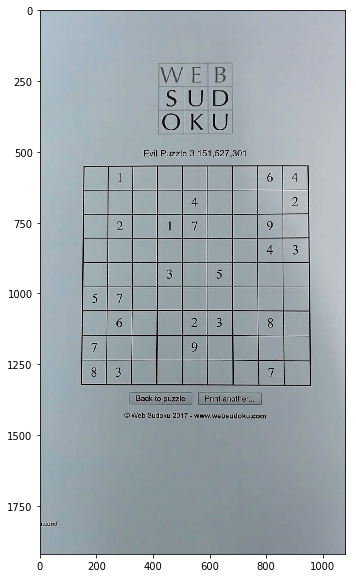

In [1]:
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# url is what shown in the IP web camera application
url='http://211.192.192.98:8080/shot.jpg'

# here is the example picture 
img = cv2.imread('example.jpg')

figsize = (15,10)
plt.figure(figsize=figsize)
_ = plt.imshow(img)

## Segment the puzzle
The first task is to segment the puzzle from the picture. The basic assumption is that the puzzle is the biggest region with convex shape in the picture. 

Firstly, an *adaptativeThreshold* method is used to extract the edge of the image (for each pixel in the image take the average value of the surrounding area). This function accepts a gray scale image, with the function cvtColor we change the color space (from RGB to gray scale). 

Then the connected contours in the image are found by the function *findContours*. After that, we filter out the contour with four sides and *isContourConvex*. 

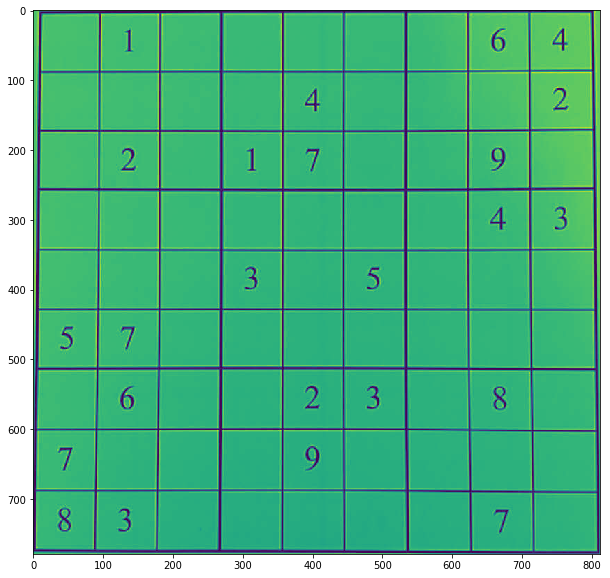

In [4]:
def getApproximateConvexArea(contour):
    appx = cv2.approxPolyDP(contour, 4, True)
    if len(appx)!=4 or not cv2.isContourConvex(appx):
        return 0
    return cv2.contourArea(appx)

def getContourImage(img, contour, target=None):
    x,y,w,h = cv2.boundingRect(contour)
    if target == None:
        w1, h1 = w, h
    elif w <= target[1] and h <= target[0]:
        w1, h1 = target[1], target[0]
    elif h/w <= target[1]/target[0]:
        w1, h1 = w, int(target[1]*w/target[0])
    else:
        w1, h1 = int(h*target[0]/target[1]), h
    x1, y1 = x + (w - w1)//2, y + (h - h1)//2
    rst = img[y1:y1+h1, x1:x1+w1]
    if w != w1 or h != h1:
        rst = cv2.resize(rst, target)
    return rst, [x1,y1,w1,h1]

def getBiggestConvexContour(img):
    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    area = [getApproximateConvexArea(c) for c in contours]
    k = np.argmax(np.array(area))
    return contours[k]

def segmentPuzzle(img):
    # smooth the picture (low-pass filtered)
    img_gray = cv2.blur(img, (3,3))
    
    # get the biggest convex contour and crop it out
    thr = cv2.adaptiveThreshold(img,255,1,1,15,15)    
    contour = getBiggestConvexContour(thr)
    img_puzzle, pos_puzzle = getContourImage(img, contour)
    return img_puzzle, pos_puzzle

# BGR format to gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_puzzle, pos_puzzle = segmentPuzzle(img_gray)
plt.figure(figsize=figsize)
_ = plt.imshow(img_puzzle)

## Split to digits
After getting the whole puzzle, the next step is to split it into pieces of digits. Of course, we can detect the lines and then split up the image based on them. However, to simpilify, one can split by equally slice the x / y axis into 9 pieces. If some of the digits are too close to the splitting boundaries, we may adjust them later. 

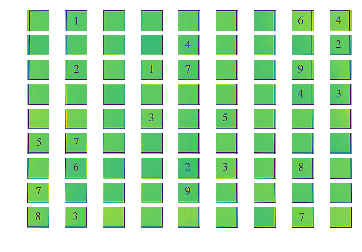

In [5]:
def getDigitImages(img):
    y = [int(k*img.shape[0]/9) for k in range(10)]
    x = [int(k*img.shape[1]/9) for k in range(10)]
    out = [[img[y[i]:y[i+1],x[j]:x[j+1]] for j in range(9)] for i in range(9)]
    return out

img_digits = getDigitImages(img_puzzle)
plt.figure(2)
for i in list(range(9)):
    for j in list(range(9)):
        plt.subplot(9,9,9*i+j+1)
        plt.imshow(img_digits[i][j])
        plt.axis('off')

## Recognize digits
Now we need to use the pretraind model for digits recognition. Unfortunately, the model pretrained by MNIST doesn't work on the captured digits. Now I will show how to train on the generated pictures.
For simplify, I use a Neural network without convolutional layers model.

1/1 [==============================] - 0s


3

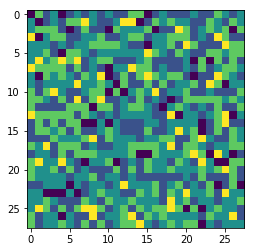

In [57]:
import keras
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
from keras import backend as K

def genPicFromDigit(digit, shape=(28,28)):
    img = np.random.randint(5, size=(*shape,3), dtype=np.uint8) + np.random.randint(low=100, high=200, size=(1), dtype=np.uint8)
    p = 4
    if digit > 0:
        cv2.putText(img, str(digit), (p,shape[0]-p), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def preProcessImg(img, shape=(28,28)):
    if K.image_data_format() == 'channels_first':
        img = img.reshape(1,1,*shape)
    else:
        img = img.reshape(1,*shape,1)
    img = img.astype('float32')/255
    return img

tmp = preProcessImg(genPicFromDigit(0))
plt.imshow(np.squeeze(tmp))
mdl.predict_classes(tmp)[0]

In [46]:
use_pretrained_model = True
bypass_conv_layer = True
if not use_pretrained_model:
    batch_size = 128
    num_classes = 10
    epochs = 12

    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    if not bypass_conv_layer:
        model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
    else:
        model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model.save('nn_mnist.h5')
else:
    mdl = load_model('nn_mnist.h5')
    print('model loaded')


model loaded


1/1 [==============================] - 0s


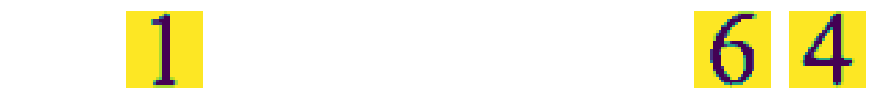

In [112]:
def removeBoundaries(img, axis=-1, thr=0.1):
    if axis == 0:
        n = int(img.shape[0]*thr)
        hline = cv2.getStructuringElement(cv2.MORPH_RECT, (1,n))
    elif axis == 1:
        n = int(img.shape[1]*thr)
        hline = cv2.getStructuringElement(cv2.MORPH_RECT, (n, 1))
    else:
        return removeBoundaries(removeBoundaries(img, 0), 1)
    H = np.copy(img)
    H = cv2.morphologyEx(H, cv2.MORPH_CLOSE, hline, (-1,-1))
    if axis == 0:
        img[0:n,:], img[-n:,:] = H[0:n,:], H[-n:,:]
    else:
        img[:,0:n], img[:,-n:] = H[:,0:n], H[:,-n:]
    return img

def contourCloseToBoundary(contour, img, thr=0.1):
    ymax, xmax = img.shape
    x,y,w,h = cv2.boundingRect(contour)
    rx = (x if x*2 + w <= xmax else xmax - (x+w)) / xmax
    ry = (y if y*2 + h <= ymax else ymax - (y+h)) / ymax
    return min(rx,ry) <= thr
       
def contourIsWholeImg(contour, img):
    ymax, xmax = img.shape
    x,y,w,h = cv2.boundingRect(contour)
    return x==0 and y==0 and w==xmax and h==ymax
    
def recognizeDigit(mdl, img, thresh=0.5):
    edges = np.copy(img)
    edges = cv2.adaptiveThreshold(edges,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,15)
    _, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    validCont = []
    for k in list(range(len(contours))):
        if contourIsWholeImg(contours[k],img) or contourCloseToBoundary(contours[k], img, thr=0.15):
            continue
        validCont.append(contours[k])
    if len(validCont) == 0:
        return 0, img
    hull = cv2.convexHull(np.vstack(validCont))
    rst, _ = getContourImage(edges, hull, (28,28))
    plt.imshow(rst)
    return str(mdl.predict_classes(rst)[0]), rst

img_mdl = [[[] for j in range(9)] for i in range(9)]
puzzle = np.zeros((9,9))
plt.figure(2,figsize=(15,15))
for i in list(range(1)):
    for j in list(range(9)):
        plt.subplot(9,9,9*i+j+1)
        puzzle[i][j], img_mdl[i][j] = recognizeDigit(mdl,img_digits[i][j])
        plt.axis('off')
        
#preProcessDigits(img_digits[0][1])


[[   6.    6.    6.    6.    6.    6.    6.    6.    6.    6.    6.    6.
    27.   41.    0.    0.   48.   41.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   6.    6.    6.    6.    6.   13.   20.   13.   13.   27.   27.   13.
     0.    0.    0.    0.    6.   27.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   6.    6.    6.    6.    6.    0.    0.   13.   55.   75.   34.    0.
     0.    0.    0.    0.   13.   68.   13.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   6.    6.    6.    6.    6.    0.    0.   13.    6.    0.    0.    0.
     0.    0.    0.    0.    0.  117.   41.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   6.    6.    6.    6.    6.   20.   41.   27.    0.    0.    0.    0.
     0.    0.    0.    0.   41.   96.   13.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   6.    6.    6.    6.    6.    6.    0.    0.   55.   20.    0.   13.
     0.    0.    0.    0.  124.  144.    0.    0.  

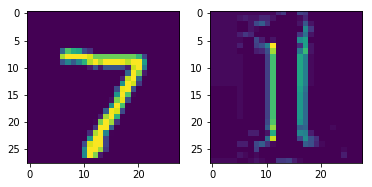

In [111]:
plt.subplot(121)
plt.imshow(np.squeeze(x_test[0]))
plt.subplot(122)
tmp = np.squeeze(img_mdl[0][1])*255 - 174
tmp = tmp/np.max(tmp,axis=None)*255
tmp = np.floor(np.maximum(tmp, 0))
plt.imshow(tmp)
print(tmp)

In [ ]:
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Replace the URL with your own IPwebcam shot.jpg IP:port
# url='http://211.192.192.98:8080/shot.jpg'
url='file:///C:/Users/yuqyang/Desktop/example.JPG'

url='file:///C:/Users/yuqyang/Downloads/1479504130.jpg'

#cv2.namedWindow("Solver")

while True:
    # Use urllib to get the image and convert into a cv2 usable format
    imgResp=urllib.request.urlopen(url)
    imgNp=np.array(bytearray(imgResp.read()),dtype=np.uint8)
    img=cv2.imdecode(imgNp,flags=cv2.IMREAD_GRAYSCALE )

    print(img.shape)
    while min(img.shape[0:2]) > 1000:
        img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)

    # put the image on screen

    #To give the processor some less stress
    #time.sleep(0.1) 

    # extract digits
    edges = cv2.Canny(img, 30, 90)
    lines = cv2.HoughLines(edges, 2, np.pi /180, 300, 0, 0)

    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    img = cv2.drawContours(img, contours, -1, (255,0,0))

    #cv2.imshow('Solver',img)
    #cv2.waitKey()
    plt.imshow(img, cmap='gray')
    plt.show()
    
    break
    if 0xFF == ord('q'):
        break

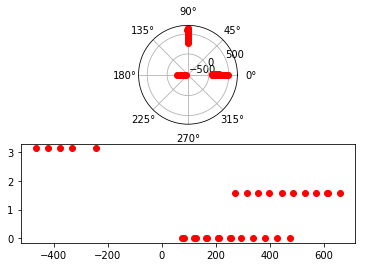

In [12]:
ln = np.squeeze(lines)
plt.figure(1)
ax = plt.subplot(211, projection='polar')
ax.plot(ln[:,1], ln[:,0], 'ro')
ax2 = plt.subplot(212)
ax2.plot(ln[:,0], ln[:,1], 'ro')